In [1]:
%pip install openpyxl

In [2]:
import numpy as np

import pandas as pd

import os

df = pd.read_excel(os.path.abspath('milano_housing_02_2_23.xlsx')) # kaggle dataset showcasing information about apartments in Milan

df.head(2)

<ipython-input-2-13d0657de828>:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


,index,rooms,m2,bathrooms,floor,condominium_expenses,date,contract,typology,total_floors,...,energy_certification,co2_emissions,elevator,floor_level,heating_centralized,heating_radiator,heating_gas,air_conditiong_centralized,air_conditioning_heat,renewable_energy_performance_index_KWh/m2
0,0,3,140.0,2,4,535,08/02/2023,sale,apartment | entire property | stately property...,6 floors,...,NaN,NaN,1,4,centralized,to radiators,methane powered,autonomous,cold/hot,NaN
1,0,4,121.0,2,3,200,17/02/2023,sale,apartment | entire property | stately property...,7 floors,...,NaN,NaN,1,3,autonomous,to radiators,gas powered,system preparation,NaN,NaN


In [3]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# keeping only m2 as feature and price as label
df = df[['m2', 'price']]

# remove abnormaly large apartments
df = df[df['m2'] <= 200]

# drop rows with missing values
df = df.dropna()

# scaling my variables
df['m2'] = scaler.fit_transform(df[['m2']])
df['price'] = scaler.fit_transform(df[['price']])

# adding a dummy variable for my model
df['ones'] = 1

df.describe()

,m2,price,ones
count,1.811000e+03,1.811000e+03,1811.0
mean,1.059340e-16,-1.020106e-16,1.0
std,1.000276e+00,1.000276e+00,0.0
min,-2.488341e+00,-1.442513e+00,1.0
25%,-7.530941e-01,-6.969401e-01,1.0
50%,-1.243816e-01,-2.799247e-01,1.0
75%,6.300734e-01,4.024642e-01,1.0
max,2.516211e+00,6.089038e+00,1.0


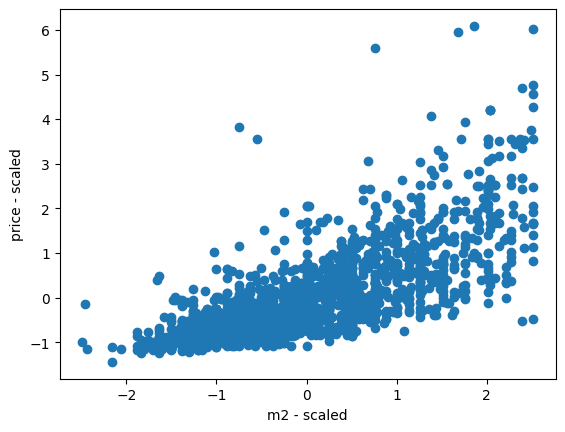

In [4]:
from matplotlib import pyplot as plt

plt.scatter(x=df.m2, y=df.price)
plt.xlabel('m2 - scaled')
plt.ylabel('price - scaled')
plt.show()

In [5]:
# We want to model the price of houses in Milan using the m2 feature only

# let's attempt to do so by using a linear regression model

# y = w0 + w1x1

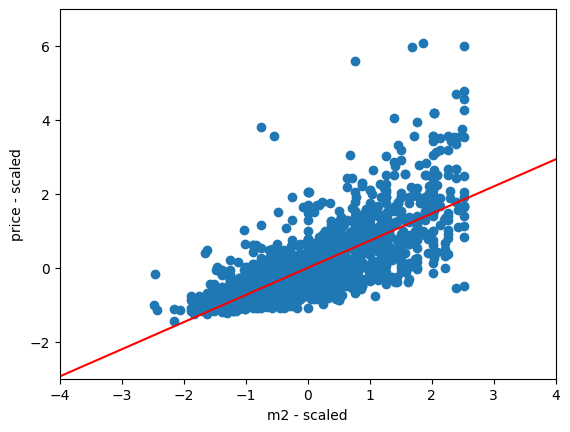

In [6]:
# APPROACH #1 - use the normal equation solution to find the best (w0, w1) which will determine the best fitting line

# W = (X^T X)^-1 X^T y

# lets define X, X^T and y so that we can calculate W

X = df[['ones', 'm2']].to_numpy().reshape(df.shape[0],df.shape[1]-1)
XT = X.transpose()
Y = df['price'].to_numpy().reshape(df.shape[0], 1)
W = np.linalg.inv(XT @ X) @ (XT @ Y)


# lets plot it and try it out

from matplotlib import pyplot as plt

xs = np.linspace(-4, 4, 100)
ys = W[0] + W[1]*xs
plt.plot(xs, ys, color='red')

plt.scatter(x=df.m2, y=df.price)
plt.xlabel('m2 - scaled')
plt.ylabel('price - scaled')
plt.ylim(-3, 7)   # x-axis range from 0 to 10
plt.xlim(-4, 4) 
plt.show()

In [7]:
# APPROACH #2 - use machine learning to "learn" the best fitting line to the data

# let's define our loss function: L = 1/2*∑[(w0 + w1x1) - y]^2

# below is the derivative of the loss function with respect to W

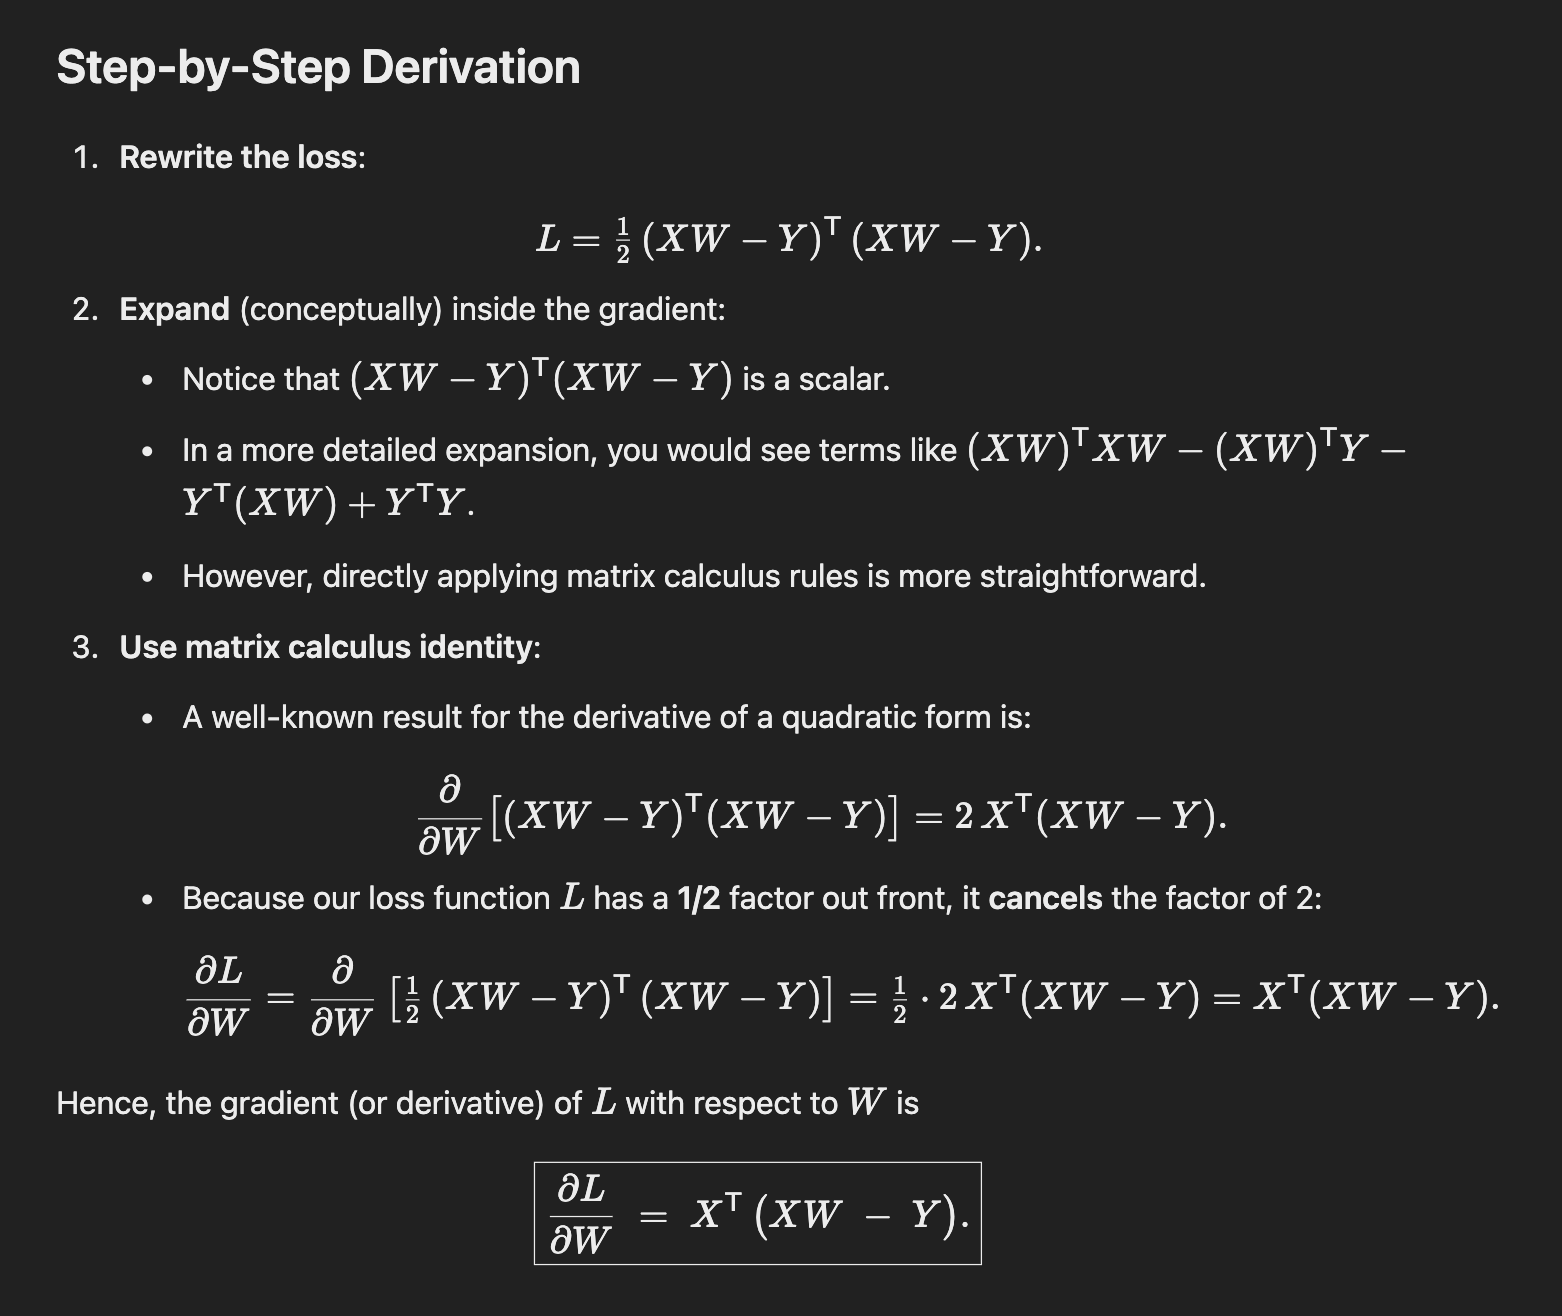

In [8]:
# X has (1811, 2) shape
# W has (2, 1) shape
# XW has (1811, 1) shape
# XW - Y has (1811, 1) shape
# X.T has (2, 1811) shape
# gradient has (2, 1) shape -- 2 vectors

# we will use GRADIENT DESCENT algorithm to updated iteratively the weights of our model converging towards the optimal solution
# point of attention: we will use BATCH GRADIENT DESCENT for now

# update rule: W -= ∂ (X.T @ (X@W - Y))   where ∂ is the learning rate hyper-parameter which will be arbitrarily set to 0.01

# heuristic: W will be randomly initialized as a zero vector to start off

# tip: we will scale our features to avoid huge gradient values (already done)

# we will be using different W to distinguish from W obtained by analytical approach which I would like to maintain

In [9]:
from tqdm import tqdm

class LR:
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        self.W = np.zeros(2).reshape(2, 1)

    def train(self, epochs, alpha):
        losses = []
        weights = []
        for epoch in tqdm(range(epochs)):
            # update weights and store updated weight
            gradient = (self.X.T @ ((self.X @ self.W) - self.Y))
            # print(f'gradient value is {gradient}')
            self.W = self.W - alpha * gradient
            #print(f'new weights are {self.W}')
            weights.append(self.W)

            # calculate loss with updated weight and store it
            loss = 1/2 * (((self.X @ self.W) - self.Y).T @ ((self.X @ self.W) - self.Y))
            #print(f'loss value is {loss[0][0]}')
            losses.append(loss[0][0])
        return losses, weights

In [10]:
lin_regression = LR(X, Y)

losses, weights = lin_regression.train(50, 0.001)

<ipython-input-9-15cdd485924f>:12: TqdmMonitorWarning: tqdm:disabling monitor support (monitor_interval = 0) due to:
can't start new thread
  for epoch in tqdm(range(epochs)):
100%|██████████| 50/50 [00:00<00:00, 16666.55it/s]


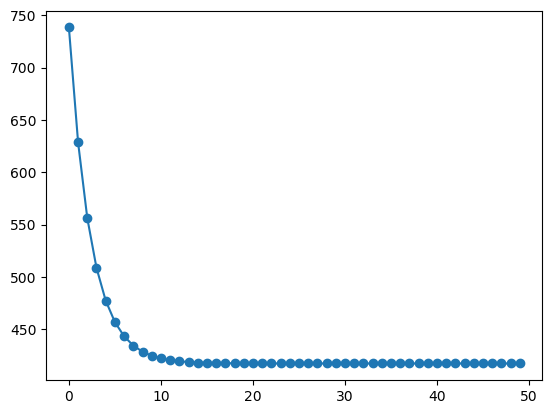

In [11]:
plt.plot(losses, marker='o')

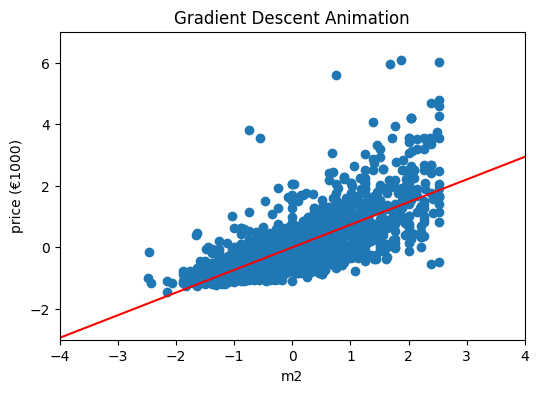

In [12]:
from matplotlib.animation import FuncAnimation

slopes = []
intercepts = []
for w in weights:
    intercept = w[0][0]
    intercepts.append(intercept)
    slope = w[1][0]
    slopes.append(slope)


# ANIMATION FUNCTIONs
def init():
    line.set_data([], [])
    return (line,)

def update(frame):
    # This function updates the line for each frame in the animation.
    # 'frame' is an integer index from 0 to iterations-1.
    
    # 1. Get the slope/intercept for the current iteration
    slope_i = slopes[frame]
    intercept_i = intercepts[frame]

    # 2. Generate x-values for plotting the line
    x_line = np.linspace(-4, 4, 100)
    # 3. Predict y-values with the current slope/intercept
    y_line = slope_i * x_line + intercept_i

    # 4. Update the line data
    line.set_data(x_line, y_line)

    ax.set_title(f"Gradient Descent Animation - iteration nr {frame}")

    return (line,)


fig, ax = plt.subplots(figsize=(6,4))
line, = ax.plot([], [], color='black', label='Model')

# CREATE & RUN THE ANIMATION
anim = FuncAnimation(
    fig,        # figure object
    update,     # function to update each frame
    frames=len(weights), 
    init_func=init,  # initialization function
    interval=400,    # time in ms between frames
    blit=True
)

# keeping initialy line obtained via analytical solution
xs = np.linspace(-4, 4, 100)
ys = W[0] + W[1]*xs
red_line, = ax.plot(xs, ys, color='red', label='Reference Line (constant)')


ax.scatter(x=scaler.fit_transform(df[['m2']]), y=scaler.fit_transform(df[['price']])) # SCALED VALUES
ax.set_xlabel('m2')
ax.set_ylabel('price (€1000)')
ax.set_ylim(-3, 7)   # x-axis range from 0 to 10
ax.set_xlim(-4, 4)
ax.set_title("Gradient Descent Animation")

plt.show()

anim.save("batch_grad_descent.gif", writer="pillow")

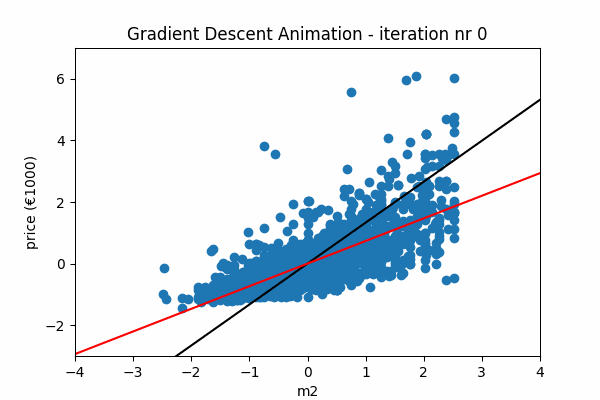

In [13]:
from IPython.display import Image
Image("batch_grad_descent.gif")

In [14]:
# OK now let's do something extremely similar with stochastic gradient descent
# that is using only 1 example per time to update the weights
# in practice this results in faster training time but a more erratic convergence towards the optimal weights

In [15]:
from tqdm import tqdm

class LR_sgd:
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        self.W = np.zeros(2).reshape(2, 1)

    def train(self, epochs, alpha):
        losses = []
        weights = []
        
        for epoch in tqdm(range(epochs)):
            # picks random example from X
            row_idx = np.random.choice(X.shape[0])
            random_example = X[row_idx].reshape(1, 2)
            y = Y[row_idx]
            
            # update weights and store updated weight based solely on the random example
            gradient = (random_example.T @ ((random_example @ self.W) - y))
            # print(f'gradient value is {gradient}')
            self.W = self.W - alpha * gradient
            # print(f'new weights are {self.W}')
            weights.append(self.W)

            # calculate loss with updated weight and store it
            loss = 1/2 * (((self.X @ self.W) - self.Y).T @ ((self.X @ self.W) - self.Y))
            #print(f'loss value is {loss[0][0]}')
            losses.append(loss[0][0])
        return losses, weights

In [16]:
lin_regression2 = LR_sgd(X, Y)

losses2, weights2 = lin_regression2.train(400, 0.01)

100%|██████████| 400/400 [00:00<00:00, 15384.74it/s]


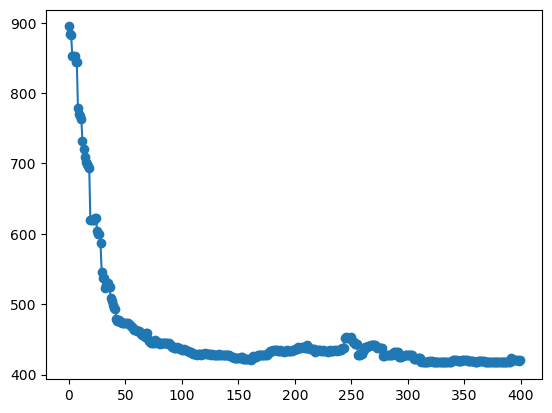

In [17]:
plt.plot(losses2, marker='o')

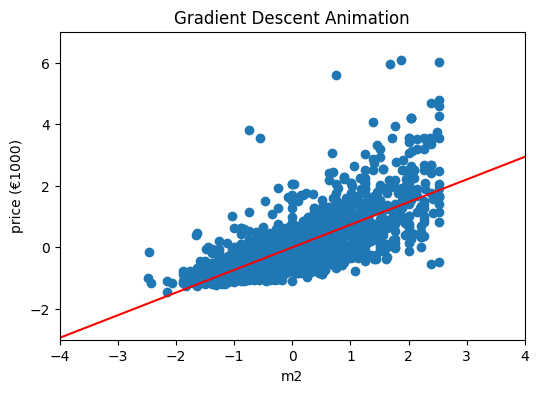

In [18]:
from matplotlib.animation import FuncAnimation

slopes = []
intercepts = []
for w in weights2:
    intercept = w[0][0]
    intercepts.append(intercept)
    slope = w[1][0]
    slopes.append(slope)


# ANIMATION FUNCTIONs
def init():
    line.set_data([], [])
    return (line,)

def update(frame):
    # This function updates the line for each frame in the animation.
    # 'frame' is an integer index from 0 to iterations-1.
    
    # 1. Get the slope/intercept for the current iteration
    slope_i = slopes[frame]
    intercept_i = intercepts[frame]

    # 2. Generate x-values for plotting the line
    x_line = np.linspace(-4, 4, 100)
    # 3. Predict y-values with the current slope/intercept
    y_line = slope_i * x_line + intercept_i

    # 4. Update the line data
    line.set_data(x_line, y_line)

    ax.set_title(f"Gradient Descent Animation - iteration nr {frame}")

    return (line,)


fig, ax = plt.subplots(figsize=(6,4))
line, = ax.plot([], [], color='black', label='Model')

# CREATE & RUN THE ANIMATION
anim = FuncAnimation(
    fig,        # figure object
    update,     # function to update each frame
    frames=len(weights2), 
    init_func=init,  # initialization function
    interval=100,    # time in ms between frames
    blit=True
)

# keeping initialy line obtained via analytical solution
xs = np.linspace(-4, 4, 100)
ys = W[0] + W[1]*xs
red_line, = ax.plot(xs, ys, color='red', label='Reference Line (constant)')


ax.scatter(x=scaler.fit_transform(df[['m2']]), y=scaler.fit_transform(df[['price']])) # SCALED VALUES
ax.set_xlabel('m2')
ax.set_ylabel('price (€1000)')
ax.set_ylim(-3, 7)   # x-axis range from 0 to 10
ax.set_xlim(-4, 4)
ax.set_title("Gradient Descent Animation")

plt.show()

anim.save("sgd.gif", writer="pillow")

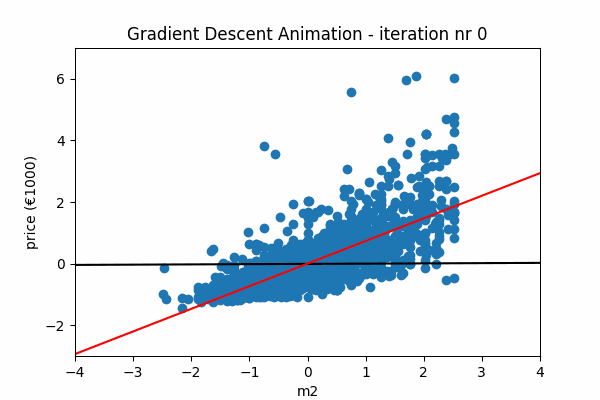

In [19]:
from IPython.display import Image
Image("sgd.gif")

In [20]:
# Final thoughts: in practice what is usually done is neither batch nor stochastic gradient descent. Instead mini-batch where you simply calculate
# the gradient using a subset of the training examples